In [26]:
%load_ext autoreload
%autoreload 2
import os 
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import datetime as dt
import time
from pandarallel import pandarallel
import re
import math

warnings.filterwarnings('ignore')

pandarallel.initialize()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [27]:
# Setting the environment variables: 
MONGO_URI = os.environ["MONGO_URI"]
MONGO_DB = os.environ["MONGO_DB"]
MONGO_COLLECTION = os.environ["MONGO_COLLECTION"]

In [29]:


pipeline = [
    {
        '$set': {
            'reviews': {
                '$objectToArray': '$reviews'
            }
        }
    }, {
        '$unwind': {
            'path': '$reviews', 
            'preserveNullAndEmptyArrays': True
        }
    }, {
        '$set': {
            'ratings': {
                '$objectToArray': '$ratings'
            }
        }
    }, {
        '$unset': '_id'
    }
]
    



In [30]:
# Connect to Mongo 
client = pymongo.MongoClient(MONGO_URI)
db = client[MONGO_DB]
collection = db[MONGO_COLLECTION]

ret_raw = collection.aggregate(pipeline)
df_raw = pd.DataFrame(ret_raw)

In [31]:
df_raw.isna().sum()

book_id      0
reviews    152
ratings      0
dtype: int64

In [32]:

df_raw.head()


,book_id,reviews,ratings
0,77203.The_Kite_Runner,"{'k': '8947952', 'v': {'user_name': 'Linda', '...","[{'k': '5 star', 'v': '1,582,498'}, {'k': 'Rat..."
1,77203.The_Kite_Runner,"{'k': '1305882067', 'v': {'user_name': 'فرشاد'...","[{'k': '5 star', 'v': '1,582,498'}, {'k': 'Rat..."
2,77203.The_Kite_Runner,"{'k': '22703379', 'v': {'user_name': 'J.G. Kee...","[{'k': '5 star', 'v': '1,582,498'}, {'k': 'Rat..."
3,77203.The_Kite_Runner,"{'k': '9020638', 'v': {'user_name': 'Britta', ...","[{'k': '5 star', 'v': '1,582,498'}, {'k': 'Rat..."
4,77203.The_Kite_Runner,"{'k': '1338106', 'v': {'user_name': 'Chris', '...","[{'k': '5 star', 'v': '1,582,498'}, {'k': 'Rat..."


In [112]:
df_ratings = df_raw.groupby('book_id').first().reset_index()

In [113]:
# one instance of a book rating
for col in df_ratings.columns:
    print(col, df_ratings[col][0])


book_id 1.Harry_Potter_and_the_Half_Blood_Prince
reviews {'k': '683662307', 'v': {'user_name': 'Jayson', 'user_id': '22106879-jayson', 'text': '(A) 86% | ExtraordinaryNotes: It dwells on the delightfully mundane aspects of the magical world, and adds new dimensions to familiar characters.', 'rating': '5 star'}}
ratings {'5 star': '2,059,562', 'Ratings_Count': '3,026,478', 'Total_Review_Count': '51,467', '4 star': '714,426', '3 star': '203,621', '2 star': '33,234', '1 star': '15,635'}


In [114]:
#we are going to have to extract the ratings from the reviews

In [115]:
df_ratings

,book_id,reviews,ratings
0,1.Harry_Potter_and_the_Half_Blood_Prince,"{'k': '683662307', 'v': {'user_name': 'Jayson'...","{'5 star': '2,059,562', 'Ratings_Count': '3,02..."
1,10008056-journal-64,"{'k': '1321408528', 'v': {'user_name': 'Jayson...","{'5 star': '7,330', 'Ratings_Count': '23,183',..."
2,10014677-front-row-center,"{'k': '443433180', 'v': {'user_name': 'Trish J...","{'5 star': '25', 'Ratings_Count': '31', 'Total..."
3,100237.Monkey,"{'k': '2151417869', 'v': {'user_name': '°°°·.°...","{'5 star': '2,366', 'Ratings_Count': '6,419', ..."
4,1002427.Teddy_Bears_1_to_10,"{'k': '12529237', 'v': {'user_name': 'Shala Ho...","{'5 star': '3', 'Ratings_Count': '15', 'Total_..."
...,...,...,...
4467,996483.10_Fat_Turkeys,"{'k': '2275927619', 'v': {'user_name': 'Donna ...","{'5 star': '337', 'Ratings_Count': '926', 'Tot..."
4468,99664.The_Painted_Veil,"{'k': '2453989852', 'v': {'user_name': 'Jim Fo...","{'5 star': '12,621', 'Ratings_Count': '42,652'..."
4469,9969571-ready-player-one,"{'k': '200552364', 'v': {'user_name': 'Kemper'...","{'5 star': '537,735', 'Ratings_Count': '1,079,..."
4470,9975313-the-humming-room,"{'k': '193495728', 'v': {'user_name': 'Misty',...","{'5 star': '1,574', 'Ratings_Count': '4,654', ..."


In [116]:
# dict_data = {d['k']: d['v'] for d in df_raw['ratings'].iloc[0]}
# dict_data

In [117]:
# df_raw['ratings'] = df_raw['ratings'].parallel_apply(lambda x: {d['k']: d['v'] for d in x})

In [118]:

df_raw['ratings'].iloc[0]

{'5 star': '1,582,498',
 'Ratings_Count': '2,935,312',
 'Total_Review_Count': '90,233',
 '4 star': '918,930',
 '3 star': '308,702',
 '2 star': '79,972',
 '1 star': '45,210'}

In [119]:
def unpack_reviews(book_id, row):
    reviews = row['reviews']
    if pd.notna(reviews):
        for review in reviews.values():
            if type(review) == dict:
                yield book_id, review['user_id'], review['text'], review['rating']



In [120]:



dfs = []
def unpack_reviews(row):
    reviews = row['reviews']
    if pd.notna(reviews):
        for review in reviews.values():
            if type(review) == dict:
                yield review['user_id'], review['text'], row['book_id'], review['rating']



In [121]:
for book_id, row in df_raw.iterrows():
    dfs.append(pd.DataFrame(unpack_reviews( row), columns=['user_id', 'text', 'book_id', 'rating']))

df_reviews = pd.concat(dfs)


In [122]:
df_reviews

,user_id,text,book_id,rating
0,613434-linda,Finished this book about a month ago but it's ...,77203.The_Kite_Runner,1 star
0,31207039,"In 2012, when I was Mathematics teacher at a p...",77203.The_Kite_Runner,5 star
0,84023-j-g-keely,This is the sort of book White America reads t...,77203.The_Kite_Runner,2 star
0,616569-britta,"""For you, a thousand times over.""""Children are...",77203.The_Kite_Runner,5 star
0,91373-chris,\nDue to the large number of negative comments...,77203.The_Kite_Runner,1 star
...,...,...,...,...
0,1395652-sean,Gives alternatives to start exploring what you...,7890698-toward-a-zero-energy-home,5 star
0,966963-kevin,"It was interesting, though it was less practic...",7890698-toward-a-zero-energy-home,4 star
0,1895489-maryann,"If I was building a house from the ground, I t...",7890698-toward-a-zero-energy-home,1 star
0,27453018-eric-gittins,Informative . Some content does not apply in o...,7890698-toward-a-zero-energy-home,None


In [123]:
df_reviews['rating'].unique

df_reviews['rating'].value_counts()

rating
5 star    41950
4 star    36760
3 star    18594
2 star     8512
1 star     5214
Name: count, dtype: int64

In [124]:
# transform 1 start, 5 star ratings to 0-5 scale 
def string_to_number(x):
    if x == '5 star':
        yield 5
    elif x == '4 star':
        yield 4
    elif x == '3 star':
        yield 3
    elif x == '2 star':
        yield 2
    elif x == '1 star':
        yield 1
    else:
        yield 0

df_reviews['rating'] = df_reviews['rating'].parallel_apply(lambda x: next(string_to_number(x)))

In [125]:
df_reviews['rating'].value_counts()

rating
5    41950
4    36760
3    18594
2     8512
1     5214
0     3431
Name: count, dtype: int64

<Axes: xlabel='rating'>

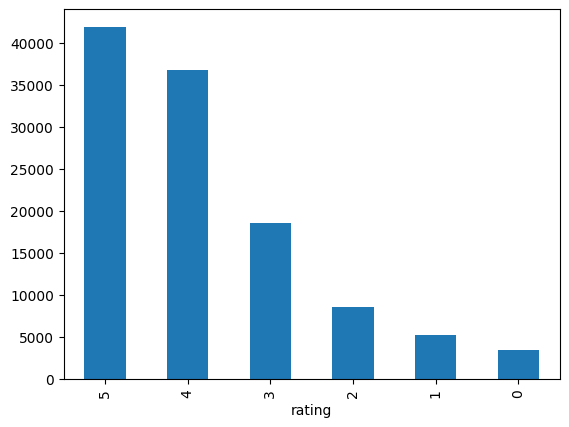

In [126]:
# lets see a distributio of the value counts
df_reviews['rating'].value_counts().plot(kind='bar')


In [127]:
df_reviews['text'] = df_reviews['text'].apply(lambda x: x.lower())
df_reviews['text'] = df_reviews['text'].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))

In [128]:
df_reviews.head()

,user_id,text,book_id,rating
0,613434-linda,finished this book about a month ago but it s ...,77203.The_Kite_Runner,1
0,31207039,in 2012 when i was mathematics teacher at a pr...,77203.The_Kite_Runner,5
0,84023-j-g-keely,this is the sort of book white america reads t...,77203.The_Kite_Runner,2
0,616569-britta,for you a thousand times over children aren t...,77203.The_Kite_Runner,5
0,91373-chris,due to the large number of negative comments ...,77203.The_Kite_Runner,1


In [129]:
df_rated = df_reviews.drop(columns=['text'])

In [130]:
df_rated.head()

,user_id,book_id,rating
0,613434-linda,77203.The_Kite_Runner,1
0,31207039,77203.The_Kite_Runner,5
0,84023-j-g-keely,77203.The_Kite_Runner,2
0,616569-britta,77203.The_Kite_Runner,5
0,91373-chris,77203.The_Kite_Runner,1


In [131]:
# save the dataframes to csv files
#user_id, text, book_id, rating
df_reviews.to_csv('reviews_with_text_cleaned.csv', index=False)
#user_id, book_id, rating
df_rated.to_csv('ratings_cleaned.csv', index=False)

In [132]:
# count instance of 0 ratings
df_reviews['rating'].value_counts()
# change 2% of the ratings to 0s randomly
df_reviews['rating'] = df_reviews['rating'].parallel_apply(lambda x: 0 if np.random.random() < 0.02 and x != 0 else x)
# count instance of 0 ratings
df_reviews['rating'].value_counts()

rating
5    41177
4    36008
3    18236
2     8340
0     5598
1     5102
Name: count, dtype: int64

In [133]:
# lets change the users into groups of people who liked a book and didnt like a book 
# 0-2 = didnt like
# 3-5 = liked
def rating_to_binary(x):
    if x == 0:
        yield 0
    elif x <= 2:
        yield 0
    elif x >= 3:
        yield 1

df_reviews['liked'] = df_reviews['rating'].parallel_apply(lambda x: next(rating_to_binary(x)))

df_reviews['liked'].value_counts()

liked
1    95421
0    19040
Name: count, dtype: int64

In [63]:
# drop duplicates

item = 'book_id'
user = 'user_id'
rating = 'rating'

mat = df_rated.pivot_table(index=user, columns=item, values=rating)
mat.shape


(51938, 4320)

In [87]:
mat

book_id,1.Harry_Potter_and_the_Half_Blood_Prince,10008056-journal-64,10014677-front-row-center,100237.Monkey,1002427.Teddy_Bears_1_to_10,10025305-clockwork-prince,100322.Assata,1003291.13_Tales_of_Horror,100365.The_Mote_in_God_s_Eye,100366.Neutron_Star,...,994232.Fifteen,99561.Looking_for_Alaska,995815.The_Outlander,9959170-the-heart-of-texas,99641.A_Density_of_Souls,996483.10_Fat_Turkeys,99664.The_Painted_Veil,9969571-ready-player-one,9975313-the-humming-room,99894.The_Boys_from_Brazil
user_id,,,,,,,,,,,,,,,,,,,,,
1-otis-chandler,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10000471-ellen-book-bellas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100014590-roemer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10001462-yvette-caradonna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000163-laura,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995733-pink,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999637-joanna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99983735-astiazh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
# check the sparsity of the matriz
sparsity = 1.0 - len(df_rated) / float(mat.shape[0] * mat.shape[1])
print('The sparsity level of Book Crossing dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of Book Crossing dataset is 99.94898609524462%


In [137]:
# the matrix is too sparse to use a matrix factorization model
# but i kept the setup of the spark calculation since i found it quite useful


In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pandas as pd

conf = SparkConf()
conf.set("spark.executor.memory","6g")
conf.set("spark.driver.memory", "6g")
conf.set("spark.driver.cores", "8")
sc = SparkContext.getOrCreate(conf)
spark = SparkSession.builder.getOrCreate()



data = spark.createDataFrame(df_rated)
data.take(5)



In [ ]:
# change the userid into a numeric values maintaining each user's id
data = data.withColumn("user_id", data["user_id"].cast("integer"))
data = data.withColumn("book_id", data["book_id"].cast("integer"))


In [82]:


train, test = data.randomSplit([0.8, 0.2], seed=42)
train.cache()
test.cache()


DataFrame[user_id: int, book_id: int, rating: bigint]

In [83]:
als = ALS(
         userCol="user_id", 
         itemCol="book_id",
         ratingCol="rating", 
         coldStartStrategy="drop"
)

In [84]:
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 100]) \
            .addGrid(als.regParam, [.1]) \
            .addGrid(als.maxIter, [10]) \
            .build()

In [85]:
evaluator = RegressionEvaluator(
           metricName="rmse", 
           labelCol="rating", 
           predictionCol="prediction")